# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)

In [10]:
# config['bs'] = 2
# config['bptt'] = 1024
# config['n_layers'] = 4
# config['n_heads'] = 4
# config['dec_layers'] = 2

In [11]:
# config['n_layers'] = 1
config['n_layers'] = 0
config['dec_layers'] = 8
config['mem_len'] = 512
config['rand_bptt'] = False

In [12]:
config

{'ctx_len': 150,
 'n_layers': 0,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 139),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 274,
 'dec_layers': 8}

In [13]:
base_path = Path('../../data/midi/v15/')

In [14]:
cache_name = 'tmp/hook_c'

## BERT Dataloading

In [15]:
# ns_dl_tfms = [mask_tfm, next_sentence_tfm]
# ns_config = config.copy()
# ns_config['bs'] *= 2
# ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
#                           y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

## S2S Dataloading

In [16]:
# s2s_dl_tfms = [mask_s2s_tfm]
# s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
#                            preloader_cls=S2SPreloader, dl_tfms=[mask_s2s_tfm], y_offset=1,
#                            shuffle_dl=True, **config)


### Load NextWord dataset (Language Model)

In [17]:
nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
                              vocab=vocab, dl_tfms=[nw_tfm], y_offset=1, 
                              train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)

In [18]:
xb,yb = nw_data.one_batch(cpu=False); 

nw_data.train_dl.dl.dataset.update_rand_bptt()

In [19]:
xb, yb

([tensor([[  8, 143,  77,  ..., 141,   4,   4],
          [  4, 143,  77,  ..., 141, 257,   4],
          [  8, 143,  77,  ...,   4,   8,   4],
          ...,
          [  8,   4,  77,  ...,   4,   8,   4],
          [  8, 143,  77,  ...,   4,   8,   4],
          [  8, 143,   4,  ..., 141,   8,   4]], device='cuda:0'),
  tensor([[4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          ...,
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4]], device='cuda:0'),
  tensor([[  8, 143,  77,  ..., 141,   8, 141],
          [  8, 143,  77,  ..., 141,   8, 141],
          [  8, 143,  77,  ..., 141,   8, 141],
          ...,
          [  8, 143,  77,  ..., 141,   8, 141],
          [  8, 143,  77,  ..., 141,   8, 141],
          [  8, 143,  77,  ..., 141,   8, 141]], device='cuda:0')],
 [tensor([[  1,   1,   1,  ...,   1,   8, 141],
          [  8,   1,   1,  ...,   1,   8, 141],
         

In [20]:
[x.shape for x in xb+yb]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

## Datasets

In [21]:
# datasets = [ns_data, s2s_data, nw_data]
datasets = [nw_data]

## Load

In [22]:
def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# Need to monkey patch pred_batch activation function for 2d array
loss_func_name = camel2snake(BertLoss.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func

In [23]:
loss_func = BertLoss(loss_mult=(0,1,1,1))
learn = bert_model_learner(datasets[0], config.copy(), 
                           loss_func=loss_func)

False


In [24]:
learn.metrics = [mask_acc, ns_acc, s2s_acc, nw_acc]

In [25]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(BertTrainer(learn, datasets))

In [26]:
[type(c) for c in learn.callbacks]

[src.unilm.BertTrainer]

In [27]:
learn = learn.to_fp16()

In [28]:
learn.model.reset()

### Training

In [29]:
# learn.lr_find(num_it=500)
# learn.recorder.plot()

In [30]:
learn.validate()

[7.3719864, tensor(0.1024), tensor(0), tensor(0), tensor(0.)]

In [31]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,mask_acc,ns_acc,s2s_acc,nw_acc,time
0,2.673968,2.625121,0.068231,0.000000,0.000000,0.351949,03:21


In [32]:
learn.save('sample_train_5')

## Load sample train

In [33]:
# load_path = base_path/'piano_duet/models/sample_train_5.pth'
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

PosixPath('../../data/midi/v15/piano_duet/models/sample_train_5.pth')

In [34]:
# learn.load('sample_train')

## Load existing

In [35]:
saved_models = get_files(base_path/'models/unilm', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v15/models/unilm/all/1_ep24_best.pth'),
 PosixPath('../../data/midi/v15/models/unilm/all/2_ep80_best.pth'),
 PosixPath('../../data/midi/v15/models/unilm/all/1_ep24.pth')]

In [36]:
# load_path = saved_models[1]
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

RuntimeError: Error(s) in loading state_dict for BertHead:
	Missing key(s) in state_dict: "s2s_decoder.layers.6.mha1.q_wgt.weight", "s2s_decoder.layers.6.mha1.k_wgt.weight", "s2s_decoder.layers.6.mha1.v_wgt.weight", "s2s_decoder.layers.6.mha1.out.weight", "s2s_decoder.layers.6.mha1.ln.weight", "s2s_decoder.layers.6.mha1.ln.bias", "s2s_decoder.layers.6.mha1.r_attn.weight", "s2s_decoder.layers.6.mha2.q_wgt.weight", "s2s_decoder.layers.6.mha2.k_wgt.weight", "s2s_decoder.layers.6.mha2.v_wgt.weight", "s2s_decoder.layers.6.mha2.out.weight", "s2s_decoder.layers.6.mha2.ln.weight", "s2s_decoder.layers.6.mha2.ln.bias", "s2s_decoder.layers.6.mha2.r_attn.weight", "s2s_decoder.layers.6.ff.layers.0.weight", "s2s_decoder.layers.6.ff.layers.0.bias", "s2s_decoder.layers.6.ff.layers.3.weight", "s2s_decoder.layers.6.ff.layers.3.bias", "s2s_decoder.layers.6.ff.layers.6.weight", "s2s_decoder.layers.6.ff.layers.6.bias", "s2s_decoder.layers.7.mha1.q_wgt.weight", "s2s_decoder.layers.7.mha1.k_wgt.weight", "s2s_decoder.layers.7.mha1.v_wgt.weight", "s2s_decoder.layers.7.mha1.out.weight", "s2s_decoder.layers.7.mha1.ln.weight", "s2s_decoder.layers.7.mha1.ln.bias", "s2s_decoder.layers.7.mha1.r_attn.weight", "s2s_decoder.layers.7.mha2.q_wgt.weight", "s2s_decoder.layers.7.mha2.k_wgt.weight", "s2s_decoder.layers.7.mha2.v_wgt.weight", "s2s_decoder.layers.7.mha2.out.weight", "s2s_decoder.layers.7.mha2.ln.weight", "s2s_decoder.layers.7.mha2.ln.bias", "s2s_decoder.layers.7.mha2.r_attn.weight", "s2s_decoder.layers.7.ff.layers.0.weight", "s2s_decoder.layers.7.ff.layers.0.bias", "s2s_decoder.layers.7.ff.layers.3.weight", "s2s_decoder.layers.7.ff.layers.3.bias", "s2s_decoder.layers.7.ff.layers.6.weight", "s2s_decoder.layers.7.ff.layers.6.bias". 
	Unexpected key(s) in state_dict: "encoder.layers.0.mhra.attention.weight", "encoder.layers.0.mhra.out.weight", "encoder.layers.0.mhra.ln.weight", "encoder.layers.0.mhra.ln.bias", "encoder.layers.0.mhra.r_attn.weight", "encoder.layers.0.ff.layers.0.weight", "encoder.layers.0.ff.layers.0.bias", "encoder.layers.0.ff.layers.3.weight", "encoder.layers.0.ff.layers.3.bias", "encoder.layers.0.ff.layers.6.weight", "encoder.layers.0.ff.layers.6.bias", "encoder.layers.1.mhra.attention.weight", "encoder.layers.1.mhra.out.weight", "encoder.layers.1.mhra.ln.weight", "encoder.layers.1.mhra.ln.bias", "encoder.layers.1.mhra.r_attn.weight", "encoder.layers.1.ff.layers.0.weight", "encoder.layers.1.ff.layers.0.bias", "encoder.layers.1.ff.layers.3.weight", "encoder.layers.1.ff.layers.3.bias", "encoder.layers.1.ff.layers.6.weight", "encoder.layers.1.ff.layers.6.bias", "encoder.layers.2.mhra.attention.weight", "encoder.layers.2.mhra.out.weight", "encoder.layers.2.mhra.ln.weight", "encoder.layers.2.mhra.ln.bias", "encoder.layers.2.mhra.r_attn.weight", "encoder.layers.2.ff.layers.0.weight", "encoder.layers.2.ff.layers.0.bias", "encoder.layers.2.ff.layers.3.weight", "encoder.layers.2.ff.layers.3.bias", "encoder.layers.2.ff.layers.6.weight", "encoder.layers.2.ff.layers.6.bias", "encoder.layers.3.mhra.attention.weight", "encoder.layers.3.mhra.out.weight", "encoder.layers.3.mhra.ln.weight", "encoder.layers.3.mhra.ln.bias", "encoder.layers.3.mhra.r_attn.weight", "encoder.layers.3.ff.layers.0.weight", "encoder.layers.3.ff.layers.0.bias", "encoder.layers.3.ff.layers.3.weight", "encoder.layers.3.ff.layers.3.bias", "encoder.layers.3.ff.layers.6.weight", "encoder.layers.3.ff.layers.6.bias", "encoder.layers.4.mhra.attention.weight", "encoder.layers.4.mhra.out.weight", "encoder.layers.4.mhra.ln.weight", "encoder.layers.4.mhra.ln.bias", "encoder.layers.4.mhra.r_attn.weight", "encoder.layers.4.ff.layers.0.weight", "encoder.layers.4.ff.layers.0.bias", "encoder.layers.4.ff.layers.3.weight", "encoder.layers.4.ff.layers.3.bias", "encoder.layers.4.ff.layers.6.weight", "encoder.layers.4.ff.layers.6.bias", "encoder.layers.5.mhra.attention.weight", "encoder.layers.5.mhra.out.weight", "encoder.layers.5.mhra.ln.weight", "encoder.layers.5.mhra.ln.bias", "encoder.layers.5.mhra.r_attn.weight", "encoder.layers.5.ff.layers.0.weight", "encoder.layers.5.ff.layers.0.bias", "encoder.layers.5.ff.layers.3.weight", "encoder.layers.5.ff.layers.3.bias", "encoder.layers.5.ff.layers.6.weight", "encoder.layers.5.ff.layers.6.bias", "encoder.layers.6.mhra.attention.weight", "encoder.layers.6.mhra.out.weight", "encoder.layers.6.mhra.ln.weight", "encoder.layers.6.mhra.ln.bias", "encoder.layers.6.mhra.r_attn.weight", "encoder.layers.6.ff.layers.0.weight", "encoder.layers.6.ff.layers.0.bias", "encoder.layers.6.ff.layers.3.weight", "encoder.layers.6.ff.layers.3.bias", "encoder.layers.6.ff.layers.6.weight", "encoder.layers.6.ff.layers.6.bias", "encoder.layers.7.mhra.attention.weight", "encoder.layers.7.mhra.out.weight", "encoder.layers.7.mhra.ln.weight", "encoder.layers.7.mhra.ln.bias", "encoder.layers.7.mhra.r_attn.weight", "encoder.layers.7.ff.layers.0.weight", "encoder.layers.7.ff.layers.0.bias", "encoder.layers.7.ff.layers.3.weight", "encoder.layers.7.ff.layers.3.bias", "encoder.layers.7.ff.layers.6.weight", "encoder.layers.7.ff.layers.6.bias", "encoder.layers.8.mhra.attention.weight", "encoder.layers.8.mhra.out.weight", "encoder.layers.8.mhra.ln.weight", "encoder.layers.8.mhra.ln.bias", "encoder.layers.8.mhra.r_attn.weight", "encoder.layers.8.ff.layers.0.weight", "encoder.layers.8.ff.layers.0.bias", "encoder.layers.8.ff.layers.3.weight", "encoder.layers.8.ff.layers.3.bias", "encoder.layers.8.ff.layers.6.weight", "encoder.layers.8.ff.layers.6.bias", "encoder.layers.9.mhra.attention.weight", "encoder.layers.9.mhra.out.weight", "encoder.layers.9.mhra.ln.weight", "encoder.layers.9.mhra.ln.bias", "encoder.layers.9.mhra.r_attn.weight", "encoder.layers.9.ff.layers.0.weight", "encoder.layers.9.ff.layers.0.bias", "encoder.layers.9.ff.layers.3.weight", "encoder.layers.9.ff.layers.3.bias", "encoder.layers.9.ff.layers.6.weight", "encoder.layers.9.ff.layers.6.bias". 

## Prediction

Prediction algo

In [32]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,7,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,song_url,section,numpy,ht_mode,midi,title,ht_time_signature,mxl,ht_offset,ht_bpm,ht_key,md5,midi_title,artist,genres,parts,source
193179,https://www.hooktheory.com/theorytab/view/ritc...,chorus,piano_duet/hooktheory/pianoroll/r/ritchie-vale...,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,la-bamba,4.0,NaN,0.0,144.0,C,aeee134e4034e5f98bb630c56d2f7f8c,La Bamba,ritchie-valen,"Pop,Rock",chorus,hooktheory_c


In [33]:
idx = 0
file = base_path/results.numpy.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [34]:
seed_len = 40
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [35]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [36]:
xb

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147]],
       device='cuda:0')

In [37]:
task_type = torch.full_like(xb, TaskType.NextWord.value)
# res = self.pred_batch(batch=((xb,task_type,xb),(xb)))[-1][0, -1] # task1, task2 - (bs x ts x vocab)

In [38]:
learn.model.reset()

In [39]:
res = learn.pred_batch(batch=((xb,task_type,xb),xb)); res

[tensor([[[0.0044, 0.0037, 0.0037,  ..., 0.0036, 0.0036, 0.0037],
          [0.0034, 0.0047, 0.0037,  ..., 0.0036, 0.0037, 0.0036],
          [0.0037, 0.0042, 0.0035,  ..., 0.0034, 0.0035, 0.0034],
          ...,
          [0.0031, 0.0036, 0.0033,  ..., 0.0033, 0.0033, 0.0033],
          [0.0036, 0.0038, 0.0035,  ..., 0.0035, 0.0036, 0.0035],
          [0.0031, 0.0036, 0.0033,  ..., 0.0033, 0.0033, 0.0033]]]),
 tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4]]),
 tensor([[[9.1561e-01, 4.7759e-04, 1.6667e-04,  ..., 4.8221e-05,
           4.0054e-05, 1.5997e-04],
          [3.8568e-04, 1.8327e-01, 3.5651e-05,  ..., 1.3244e-05,
           2.3935e-05, 2.4551e-05],
          [2.4268e-06, 4.4008e-06, 3.0519e-08,  ..., 2.2241e-08,
           5.8826e-08, 7.9160e

In [40]:
preds = loss_batch(learn.model.eval(), (xb,task_type,xb), yb); preds

([tensor([[[ 0.1938,  0.0140,  0.0234,  ...,  0.0022, -0.0004,  0.0165],
           [ 0.0140,  0.3479,  0.1149,  ...,  0.0867,  0.1130,  0.0864],
           [-0.0170,  0.1159, -0.0717,  ..., -0.0933, -0.0694, -0.0841],
           ...,
           [-0.0279,  0.1076,  0.0144,  ...,  0.0207,  0.0187,  0.0314],
           [-0.0104,  0.0472, -0.0249,  ..., -0.0374, -0.0192, -0.0329],
           [-0.0279,  0.1076,  0.0144,  ...,  0.0207,  0.0187,  0.0314]]],
         dtype=torch.float16),
  tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
           4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
           4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
           4, 4, 4, 4, 4, 4, 4, 4, 4, 4]]),
  tensor([[[ 6.0586, -2.8809, -3.6738,  ..., -4.3164, -4.9531, -4.1758],
           [ 0.4409,  5.3867, -4.0352,  ..., -4.4609, -4.4492, -5.0898],
           [-1.6709, -2.1230, -6.9414,  ..., -6.8086, -6.3633, -6.1953],
 

In [41]:
last = res[-1][0, -1]; last[143]

tensor(0.0050)

In [42]:

idx = torch.multinomial(res[-1][0, -1], 1).item(); idx

8

In [51]:

def predict_nw(self, xb:Tensor, n_words:int=128):
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy().squeeze()
    yb = torch.ones_like(xb)
    new_idx = []
#     self.mask = False
    self.model.reset()

    for i in progress_bar(range(n_words), leave=True):
        print(xb)
        task_type = torch.full_like(xb, TaskType.NextWord.value)
        
        # Masking last - bert
#         mask_last = torch.cat((xb, torch.tensor(vocab.mask_idx, device=xb.device).view(1, 1)), dim=-1)
#         res = self.pred_batch(batch=((mask_last,task_type,mask_last),(yb)))[0][0, -1] # task1, task2 - (bs x ts x vocab)
        
        # Next Word
        res = self.pred_batch(batch=((xb,task_type,xb),xb))[-1][0, -1] # task1, task2 - (bs x ts x vocab)

        # Use first temperatures value if last prediction was duration
        res.pow_(1 / (0.5))

        idx = torch.multinomial(res, 1).item()
    
        new_idx.append(idx)
#         t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
#         xb = torch.cat((xb, t_idx), dim=-1)
        xb = xb.new_tensor([idx])[None]
        
#     self.mask = True
    return np.array(new_idx), seed


In [52]:
# vocab.itos[143]

In [53]:
if xb.shape[0] > 1: xb = xb[0][None]
seed = xb.cpu().numpy().squeeze()
yb = torch.ones_like(xb)
res = learn.pred_batch(batch=((xb, torch.full_like(xb, TaskType.NextWord.value),xb),(yb)))
res[-1][0, -1][141]

tensor(0.0063)

In [54]:
out_s, seed_s = predict_nw(learn, xb, n_words=40)

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147]],
       device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[143]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[141]], device='cuda:0'

In [55]:
[vocab.itos[i] for i in out_s]

['xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd4',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd4',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'xxsep',
 'd2',
 'n64',
 'd4']

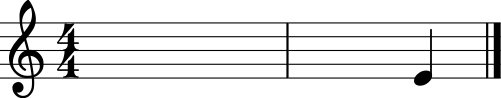

In [56]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()